In [5]:
import numpy as np
import pandas as pd
from random import shuffle
import pickle
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import random
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tqdm
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os


In [6]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   249M      0  0:00:03  0:00:03 --:--:--  249M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
def data_loader():
  cat_folder = './PetImages/Cat/'
  dog_folder = './PetImages/Dog/'
  count={cat_folder:0, dog_folder:1}
  cat=[]
  dog=[]
  for i in count:
    for f in tqdm(os.listdir(i)):
      path = os.path.join(i, f)
      image =cv2.imread(path)
      if image is not None and i=='./PetImages/Cat/':
        image = cv2.resize(image,(224, 224))
        cat.append([np.array(image),0])    
        
      elif image is not None and i=='./PetImages/Dog/':
        image = cv2.resize(image,(224, 224))
        dog.append([np.array(image),1]) 

  return cat,dog


In [ ]:
catnp_x = np.array([i[0] for i in data_loader()[0][:2000]]).reshape(-1,224,224,3)
dognp_x = np.array([i[0] for i in data_loader()[1][:2000]]).reshape(-1,224,224,3)
x = np.concatenate((catnp_x, dognp_x))

catnp_y = np.array([i[1] for i in data_loader()[0][:2000]])
dognp_y = np.array([i[1] for i in data_loader()[1][:2000]])
y = np.concatenate((catnp_y, dognp_y)) 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle = True)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [12]:
inputShape = tf.keras.layers.Input(shape = (224,224,3))

x = tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu')(inputShape)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.1)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model1 = tf.keras.Model(inputs = inputShape,outputs = x)


model1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856 

1/1 [==============================] - 7s 7s/step


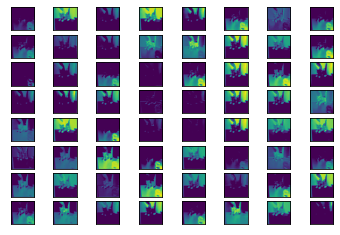

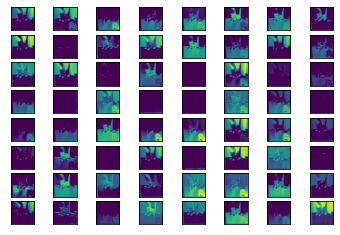

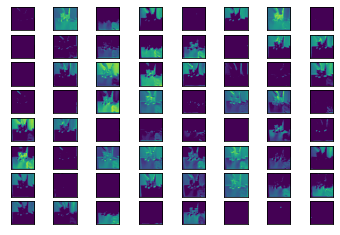

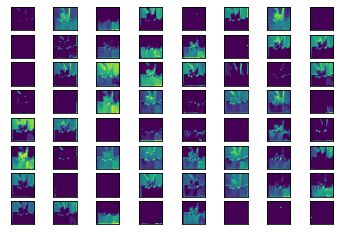

In [14]:
from numpy import expand_dims
from keras.applications.vgg16 import preprocess_input
ixs = [2, 5, 9, 11]
outputs = [model1.layers[i].output for i in ixs]
model = tf.keras.models.Model(inputs=model1.input, outputs=outputs)
img = tf.keras.preprocessing.image.load_img('./PetImages/Cat/0.jpg', target_size=(224, 224))
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
square = 8
for fmap in feature_maps:
	ix = 1
	for _ in range(square):
		for _ in range(square):
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			plt.imshow(fmap[0, :, :, ix-1])
			ix += 1
	plt.show()



In [15]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/cats-dogs-01-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-4)


model1.compile(
    loss = 'binary_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history1 = model1.fit(
    x_train,y_train,
    epochs = 20,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=my_callbacks)

Epoch 1/20
188/188 [==============================] - 20s 93ms/step - loss: 0.7226 - accuracy: 0.6173 - val_loss: 1.2429 - val_accuracy: 0.5060 - lr: 1.0000e-04
Epoch 2/20
188/188 [==============================] - 16s 83ms/step - loss: 0.5421 - accuracy: 0.7397 - val_loss: 1.6070 - val_accuracy: 0.4910 - lr: 1.0000e-04
Epoch 3/20
188/188 [==============================] - 17s 88ms/step - loss: 0.4300 - accuracy: 0.7920 - val_loss: 0.7250 - val_accuracy: 0.6340 - lr: 1.0000e-04
Epoch 4/20
188/188 [==============================] - 16s 83ms/step - loss: 0.2882 - accuracy: 0.8737 - val_loss: 0.6308 - val_accuracy: 0.7060 - lr: 1.0000e-04
Epoch 5/20
188/188 [==============================] - 16s 83ms/step - loss: 0.1803 - accuracy: 0.9283 - val_loss: 0.6283 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 6/20
188/188 [==============================] - 16s 83ms/step - loss: 0.0863 - accuracy: 0.9750 - val_loss: 0.6563 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 7/20
188/188 [==============

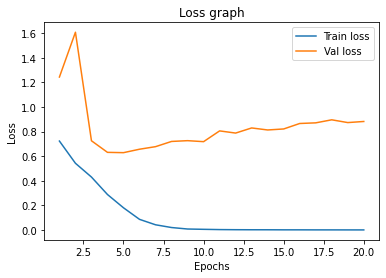

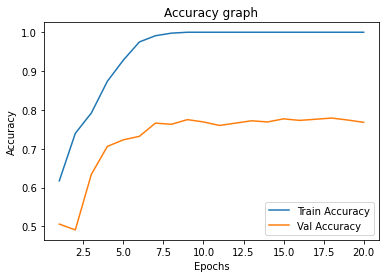

In [16]:
dict1 = history1.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()


plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [19]:
vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    input_shape=(224,224,3),
)


for layer in vgg.layers:
  layer.trainable = False


last_layer = vgg.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)


vgg_model = tf.keras.Model(inputs=vgg.input ,outputs=x)

vgg_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [20]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/cats-dogs-vgg-frozen-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-3)


vgg_model.compile(
    loss = 'binary_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history1 = vgg_model.fit(
    x_train,y_train,
    epochs = 20,
    batch_size = 128,
    validation_data=(x_test,y_test),
    callbacks=my_callbacks)

Epoch 1/20
188/188 [==============================] - 22s 112ms/step - loss: 0.3533 - accuracy: 0.8363 - val_loss: 0.3035 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 2/20
188/188 [==============================] - 21s 113ms/step - loss: 0.2173 - accuracy: 0.9030 - val_loss: 0.1699 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 3/20
188/188 [==============================] - 21s 109ms/step - loss: 0.2035 - accuracy: 0.9133 - val_loss: 0.2516 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 4/20
188/188 [==============================] - 21s 109ms/step - loss: 0.1930 - accuracy: 0.9150 - val_loss: 0.1844 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 5/20
188/188 [==============================] - 21s 112ms/step - loss: 0.1805 - accuracy: 0.9190 - val_loss: 0.1777 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 6/20
188/188 [==============================] - 21s 111ms/step - loss: 0.1579 - accuracy: 0.9260 - val_loss: 0.1629 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 7/20
188/188 [==============================] 

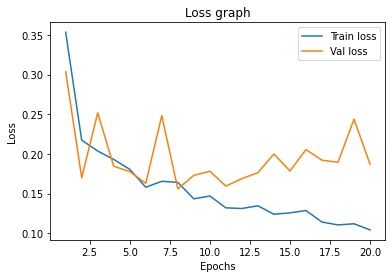

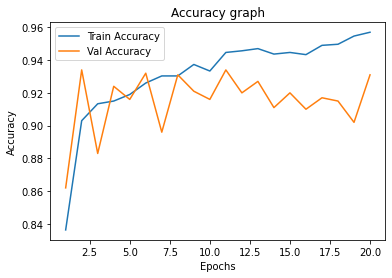

In [24]:
dict1 = history1.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()


plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()

In [21]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,              
      rotation_range = 30,           
      width_shift_range = 0.3,       
      height_shift_range = 0.3,      
      horizontal_flip = True,        
      fill_mode = 'nearest')      

train_generator = train_datagen.flow(x_train, y_train)

In [22]:
vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    input_shape=(224,224,3),
)


for layer in vgg.layers:
  layer.trainable = False


last_layer = vgg.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)


vgg_model = tf.keras.Model(inputs=vgg.input ,outputs=x)

vgg_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
my_callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=15),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/cats-dogs-vgg-frozen-loss_{loss:.3f}_val_acc{val_accuracy:.3f}.h5',
        monitor = 'val_accuracy',
        save_best_only = True
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'loss',
        factor = 0.1,
        patience = 3,
        min_lr = 1e-5
    ),
]

adam = tf.keras.optimizers.Adam(1e-3)


vgg_model.compile(
    loss = 'binary_crossentropy' ,
    optimizer=adam,
	metrics=["accuracy"]
)

history1 = vgg_model.fit(
    train_generator,
    epochs = 20,
    batch_size = 128,
    validation_data=x_test,y_test,
    callbacks=my_callbacks)

Epoch 1/20
94/94 [==============================] - 43s 444ms/step - loss: 0.2638 - accuracy: 0.8797 - val_loss: 0.1706 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - 41s 434ms/step - loss: 0.2504 - accuracy: 0.8887 - val_loss: 0.1754 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - 42s 445ms/step - loss: 0.2450 - accuracy: 0.8837 - val_loss: 0.1648 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - 41s 432ms/step - loss: 0.2491 - accuracy: 0.8877 - val_loss: 0.2141 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 5/20
94/94 [==============================] - 41s 434ms/step - loss: 0.2590 - accuracy: 0.8850 - val_loss: 0.1685 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 6/20
94/94 [==============================] - 41s 433ms/step - loss: 0.2459 - accuracy: 0.8857 - val_loss: 0.1653 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 7/20
94/94 [==============================] - 42s 443ms/st

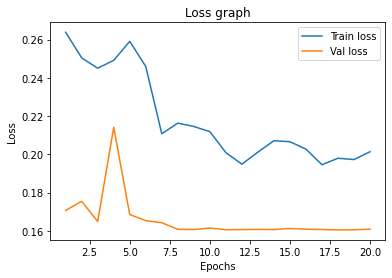

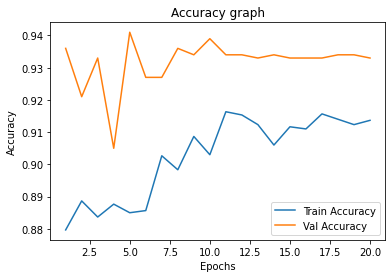

In [26]:
dict1 = history1.history
loss = dict1['loss']
val_loss = dict1['val_loss']
accuracy = dict1['accuracy']
val_accuracy = dict1['val_accuracy']
epochs = range(1,len(loss)+1)


plt.plot(epochs,loss, label='Train loss')
plt.plot(epochs,val_loss,label='Val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss graph")
plt.show()


plt.clf()
plt.plot(epochs,accuracy, label='Train Accuracy')
plt.plot(epochs,val_accuracy,label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy graph")
plt.show()